In [1]:
import os
import xarray as xr
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import cartopy.crs as ccrs
import matplotlib.dates as mdates
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm
from datetime import datetime
import matplotlib.patches as mpatches
from skimage.io import imread
from scipy.optimize import curve_fit

import matplotlib.patheffects as pe
from matplotlib.colors import Normalize
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 15})

In [2]:
DATA_PATH = '../data/converted/'

site_lats = [46.532, 44.908, 61.845, 47.97, 59.81, 67.84, 37.665, 42.686, 44.232]
site_lons = [-87.548, -84.719, 24.287, -123.58, 7.21, 20.41, 128.7, -73.823, -79.781]
site_name_offsets_y = [4, -6, 3.5, 1.5, 0, 0.75, -4, -6, 2.5]
site_name_offsets_x = [-7, -7, 5, -7, -15, -17, 8, -2, 1.5]
names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'GCP']
colors = ['black', 'r', 'g', 'b', 'orange', 'c', 'm', 'gold', 'purple']

In [3]:
# Initialize a dictionary to store the results
site_totals = {}
site_dates = {}

# Loop through all subfolders in the DATA_PATH directory
for subdir, _, _ in os.walk(DATA_PATH):
    # Extract the site ID from the folder name
    folder_name = os.path.basename(subdir)
    year_site_split = folder_name.split('_')
    if len(year_site_split) == 2:
        year, site_id = year_site_split

        # Initialize site info if not already present
        if site_id not in site_totals:
            site_totals[site_id] = {'total_files': 0, 'total_non_nan': 0, 'total_with_nan': 0}

        # Construct the path to the netCDF files
        netcdf_path = os.path.join(subdir, "netCDF/edensity_distributions")

        # If the folder exists, proceed
        if os.path.exists(netcdf_path):
            # Loop through all .nc files in the netcdf_path
            for filename in os.listdir(netcdf_path):
                if filename.endswith(".nc"):
                    site_totals[site_id]['total_files'] += 1
                    file_path = os.path.join(netcdf_path, filename)

                    # Open the netCDF file using xarray
                    with xr.open_dataset(file_path) as ds:
                        # Extract the 'rho' variable
                        rho = ds['rho'].values  # This assumes 'rho' is present in the file

                        # Count non-NaN entries along the x-dimension where at least one y value in the column is non-NaN
                        non_nan_count = np.sum([1 for column in rho.T if not np.all(np.isnan(column))])
                        site_totals[site_id]['total_non_nan'] += non_nan_count

                        # Count total entries including NaN
                        site_totals[site_id]['total_with_nan'] += 1440

                        # Keep track of dates for plotting later
                        date_str = filename.split('_')[0]  # Modify this to suit how the date is stored
                        if site_id not in site_dates:
                            site_dates[site_id] = []
                        if non_nan_count > 0:
                            site_dates[site_id].append(date_str[3:11])

del site_dates['NSA']
site_dates['OLY'] = site_dates['HUR']
del site_dates['HUR']
site_dates['HAK'] = site_dates['HAUK']
del site_dates['HAUK']

# Print the results
for site_id, stats in site_totals.items():
    print(f"Site ID: {site_id}")
    print(f"Total files processed: {stats['total_files']}")
    print(f"Total non-NaN entries: {stats['total_non_nan']}")
    print(f"Total entries including NaN: {stats['total_with_nan']}")
    print("------")



In [4]:

colors_temp = ['r', 'g', 'orange', 'gold', 'c', 'magenta', 'magenta', 'black', 'b']

# Initialize the figure
fig, ax = plt.subplots(figsize=(16,6))
ax.set_axisbelow(True)
# Sort site_dates keys alphabetically
sorted_keys = sorted(site_dates.keys())
plt.grid()
# Plot the data
for i, site_id in enumerate(sorted_keys):
    dates = site_dates[site_id]
    dates_datetime = [datetime.strptime(date, '%Y%m%d') for date in dates]
    ax.scatter(dates_datetime, [i]*len(dates_datetime), marker='|', s=550, color=colors_temp[i], label=site_id)

# Format the plot
ax.yaxis.set_ticks(range(len(sorted_keys)))
ax.yaxis.set_ticklabels(sorted_keys)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.ylim(-1, 9)  # Modify the upper limit according to your number of sites
ax.set_xlabel('Date')
ax.set_ylabel('Site')
ax.set_title('Dataset Temporal Coverage')
# plt.legend()

# Show the plot
plt.show()

In [5]:

def plot_map():
    plt.figure(figsize=(40, 40))
    ax = plt.axes(projection=ccrs.LambertConformal(cutoff=30))

    fname = os.path.join('/Users/fraserking/Development/global_ml/NE1_50M_SR_W', 'NE1_50M_SR_W.tif')
    ax.imshow(imread(fname), origin='upper', transform=ccrs.PlateCarree())

    for i, lat in enumerate(site_lats):
        plt.scatter(site_lons[i], lat, color=colors[i], marker='o', edgecolors=['white'], linewidth=6, s=4000, transform=ccrs.Geodetic())
        plt.text(site_lons[i] + site_name_offsets_x[i], lat + site_name_offsets_y[i], names[i], fontsize=60, color=colors[i], path_effects=[pe.withStroke(linewidth=10, foreground="white")], transform=ccrs.Geodetic())  # adjust text position as needed
        
    ax.coastlines(resolution='110m')
    ax.gridlines(linewidth=3, color='black', linestyle='--', alpha=0.2)

    plt.show()

plot_map()

Working on MQT


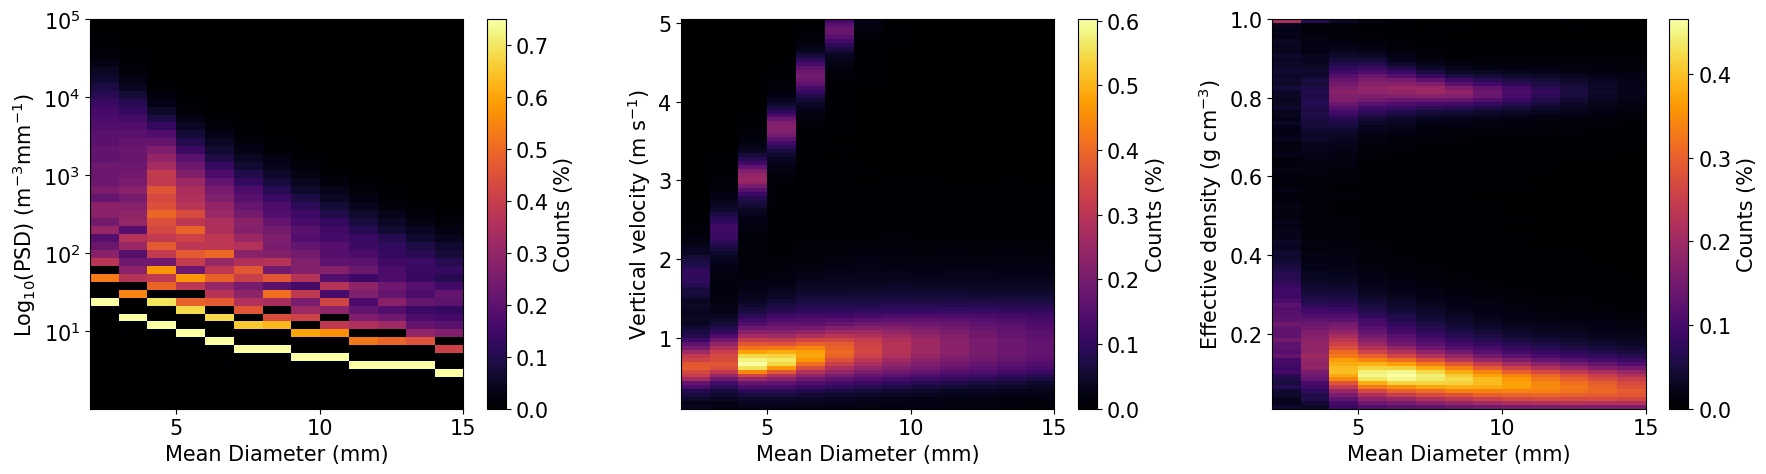

In [15]:
def create_hists_for_sites():

    names = ['MQT', 'APX', 'FIN', 'HUR', 'HAUK', 'KIS', 'KO1', 'KO2', 'IMP']
    base_folder = '/Users/fraserking/Development/pip_processing/data/converted'

    cmap = plt.get_cmap('inferno')
    cmap.set_bad(color='black')

    for site_name in names:
        print(f"Working on {site_name}")
        
        dsd_list = []
        dsd_height_list = []
        vvd_list = []
        vvd_height_list = []
        rho_list = []
        rho_height_list = []

        subdirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
        matching_subdirs = [d for d in subdirs if site_name in d]
        
        for subdir in matching_subdirs:
            full_path = os.path.join(base_folder, subdir)
            # print(f"Processing subdirectory: {full_path}")

            pip_vars = ['netCDF/particle_size_distributions', 'netCDF/edensity_distributions', 'netCDF/velocity_distributions']
            for i,var in enumerate(pip_vars):
                netcdf_path = os.path.join(full_path, var)
                if os.path.exists(netcdf_path):
                    all_files = os.listdir(netcdf_path)
                    nc_files = [f for f in all_files if f.endswith('.nc')]
                    
                    for nc_file in nc_files:
                        nc_file_path = os.path.join(netcdf_path, nc_file)
                        # print(f"Processing file: {nc_file_path}")
                        ds_pip = xr.open_dataset(nc_file_path)   

                        if i == 0:
                            dsd = ds_pip['psd'].values
                            dsd_height = np.repeat(np.arange(1, 132), dsd.shape[0])
                            dsd_list.append(dsd.T.flatten())
                            dsd_height_list.append(dsd_height)
                        elif i == 1:
                            rho = ds_pip['rho'].values
                            rho_height = np.repeat(np.arange(1, 132), rho.shape[0])
                            rho_list.append(rho.T.flatten())
                            rho_height_list.append(rho_height)
                        elif i == 2:
                            vvd = ds_pip['vvd'].values
                            vvd_height = np.repeat(np.arange(1, 132), vvd.shape[0])
                            vvd_list.append(vvd.T.flatten())
                            vvd_height_list.append(vvd_height)



        dsd_ds = np.concatenate(dsd_list)
        dsd_height_ds = np.concatenate(dsd_height_list)
        vvd_ds = np.concatenate(vvd_list)
        vvd_height_ds = np.concatenate(vvd_height_list)
        rho_ds = np.concatenate(rho_list)
        rho_height_ds = np.concatenate(rho_height_list)

        bin_DSD = np.linspace(.001,5,50) #54
        bin_VVD = np.arange(0.1,5.1,0.05)
        bin_eden = np.arange(0.01,1.01,0.01)    
        bin_D = np.arange(0,26,1)
        
        dsd_x = np.asarray(dsd_ds).flatten()
        dsd_y = np.asarray(dsd_height_ds).flatten()
        dsd_x[dsd_x<=0] = np.nan
        mask = ~np.isnan(dsd_x)
        dsd_x = dsd_x[mask]
        dsd_y = dsd_y[mask]
        dsd_hist, dsd_xedges, dsd_yedges = np.histogram2d(dsd_y, np.ma.log10(dsd_x), (bin_D, bin_DSD))

        vvd_x = np.asarray(vvd_ds).flatten()
        vvd_y = np.asarray(vvd_height_ds).flatten()
        vvd_x[vvd_x<=0] = np.nan
        mask = ~np.isnan(vvd_x)
        vvd_x = vvd_x[mask]
        vvd_y = vvd_y[mask]
        vvd_hist, vvd_xedges, vvd_yedges = np.histogram2d(vvd_y, vvd_x, (bin_D, bin_VVD))
        
        rho_x = np.asarray(rho_ds).flatten()
        rho_y = np.asarray(rho_height_ds).flatten()
        rho_x[rho_x<=0] = np.nan
        mask = ~np.isnan(rho_x)
        rho_x = rho_x[mask]
        rho_y = rho_y[mask]
        rho_hist, rho_xedges, rho_yedges = np.histogram2d(rho_y, rho_x, (bin_D, bin_eden))

        # Normalize histograms to percentages of total counts
        dsd_hist = dsd_hist / dsd_hist.sum() * 100
        vvd_hist = vvd_hist / vvd_hist.sum() * 100
        rho_hist = rho_hist / rho_hist.sum() * 100

        fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

        # plt.suptitle("MQT PIP Full Period 2D-Histograms")

        # Y-tick labels for logarithmic scale
        yticks_labels = [r'$10^{0}$', r'$10^{1}$', r'$10^{2}$', r'$10^{3}$', r'$10^{4}$', r'$10^{5}$']
        yticks_values = [0, 1, 2, 3, 4, 5]

        for ax in axes:
            ax.set_yticks(yticks_values)
            ax.set_yticklabels(yticks_labels)

        # First subplot
        im0 = axes[0].imshow(dsd_hist.T, origin='lower', vmin=0, vmax=0.75, cmap=cmap, aspect='auto',
                            extent=[dsd_xedges[0], dsd_xedges[-1], dsd_yedges[0], dsd_yedges[-1]])
        cbar0 = plt.colorbar(im0, ax=axes[0])
        cbar0.set_label('Counts (%)')

        axes[0].set_ylabel(r"Log$_{10}$(PSD) (m$^{-3}$mm$^{-1}$)")
        axes[0].set_xlabel("Mean Diameter (mm)")
        axes[0].set_xlim((2, 15))

        # Second subplot
        im1 = axes[1].imshow(vvd_hist.T, origin='lower', cmap=cmap, aspect='auto',
                            extent=[vvd_xedges[0], vvd_xedges[-1], vvd_yedges[0], vvd_yedges[-1]])
        cbar1 = plt.colorbar(im1, ax=axes[1])
        cbar1.set_label('Counts (%)')

        axes[1].set_ylabel("Vertical velocity (m s$^{−1}$)")
        axes[1].set_xlabel("Mean Diameter (mm)")
        axes[1].set_yscale('linear')
        axes[1].set_xlim((2, 15))

        # Third subplot
        im2 = axes[2].imshow(rho_hist.T, origin='lower', cmap=cmap, aspect='auto',
                            extent=[rho_xedges[0], rho_xedges[-1], rho_yedges[0], rho_yedges[-1]])
        cbar2 = plt.colorbar(im2, ax=axes[2])
        cbar2.set_label('Counts (%)')

        axes[2].set_ylabel("Effective density (g cm$^{-3}$)")
        axes[2].set_xlabel("Mean Diameter (mm)")
        axes[2].set_xlim((2, 15))
        axes[2].set_yscale('linear')

        plt.tight_layout()
        plt.show()

        break
    
create_hists_for_sites()

In [7]:

def create_n0_lambda_for_sites():

    names = ['MQT', 'APX', 'FIN', 'HUR', 'HAUK', 'KIS', 'KO1', 'KO2', 'IMP']
    base_folder = '/Users/fraserking/Development/pip_processing/data/converted'

    # Initialize arrays to store N0 and lambda values
    site_N_0_array = []
    site_lambda_array = []

    for site_name in names:
        print(f"Working on {site_name}")
        
        N_0_array = []
        lambda_array = []
        subdirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
        matching_subdirs = [d for d in subdirs if site_name in d]
        
        for subdir in matching_subdirs:
            full_path = os.path.join(base_folder, subdir)
            print(f"Processing subdirectory: {full_path}")

            pip_vars = ['netCDF/particle_size_distributions']
            for i,var in enumerate(pip_vars):
                netcdf_path = os.path.join(full_path, var)
                if os.path.exists(netcdf_path):
                    all_files = os.listdir(netcdf_path)
                    nc_files = [f for f in all_files if f.endswith('.nc')]
                    
                    for nc_file in nc_files:
                        nc_file_path = os.path.join(netcdf_path, nc_file)
                        # print(f"Processing file: {nc_file_path}")
                        ds_pip = xr.open_dataset(nc_file_path)   
                        dsd_values = ds_pip['psd'].values
                        bin_centers = ds_pip['bin_centers'].values

                        func = lambda t, a, b: a * np.exp(-b*t)

                        # Loop over each minute
                        for i in range(dsd_values.shape[0] - 5): # Subtract 5 to ensure we can get a 15-min running average for every point

                            # Calculate 15-minute running average for this minute and all bins
                            running_avg = np.mean(dsd_values[i:i+5, :], axis=0)

                            # Remove nans from running_avg and corresponding bin_centers
                            valid_indices = ~np.isnan(running_avg)
                            running_avg = running_avg[valid_indices]
                            valid_bin_centers = bin_centers[valid_indices]

                            # If there are no valid data points left after removing NaNs, skip this minute
                            if running_avg.size == 0:
                                N_0_array.append(np.nan)
                                lambda_array.append(np.nan)
                                continue

                            # Perform curve fitting
                            try:
                                popt, pcov = curve_fit(func, valid_bin_centers, running_avg, p0 = [1e4, 2], maxfev=600)
                                if popt[0] > 0 and popt[0] < 10**7 and popt[1] > 0 and popt[1] < 10:
                                    N_0_array.append(popt[0])
                                    lambda_array.append(popt[1])
                            except RuntimeError:
                                N_0_array.append(np.nan)
                                lambda_array.append(np.nan)

        site_N_0_array.append(N_0_array)
        site_lambda_array.append(lambda_array)

    return site_N_0_array, site_lambda_array
    
site_N_0_array, site_lambda_array = create_n0_lambda_for_sites()


Working on MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2017_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2016_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2015_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2022_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2021_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2020_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2018_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2019_MQT
Working on APX
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2022_APX
Working on FIN
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2019_FIN
Processing subd

In [8]:
concatenated_subarray = site_N_0_array[6] + site_N_0_array[7]
site_N_0_array[6] = concatenated_subarray
del site_N_0_array[7]

concatenated_subarray = site_lambda_array[6] + site_lambda_array[7]
site_lambda_array[6] = concatenated_subarray
del site_lambda_array[7]

In [9]:
bin_N0 = np.arange(0, 6.2, 0.1)
bin_lambda = np.arange(-1, 1.05, 0.005)
cmap = plt.get_cmap('inferno')
cmap.set_bad(color='black')
names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'GCP']

fig, axes = plt.subplots(3, 3, figsize=(16,16), sharey=False)
axes = axes.flatten()
for i in range(8):
    print(i)
    n0_lambda_hist = np.histogram2d(np.ma.log10(site_lambda_array[i]), np.ma.log10(site_N_0_array[i]), (bin_lambda, bin_N0))

    hist = 100 * n0_lambda_hist[0].T / np.sum(n0_lambda_hist[0].T)
    pcm = axes[i].pcolormesh(bin_lambda, bin_N0, hist, cmap=cmap, norm=LogNorm(vmin=0.01, vmax=hist.max()))
    axes[i].set_facecolor('#440154')
    axes[i].set_xlim(-0.4, 0.2)
    axes[i].set_ylim(0, 5)
    axes[i].set_ylabel("$Log_{10}(N_{0})$ (m$^{-3}$mm$^{-1}$)")
    axes[i].set_xlabel("$Log_{10}(λ)$ (mm$^{-1}$)")
    axes[i].set_title(names[i])
    # cb = fig.colorbar(pcm, ax=axes[i], extend="max")
    # cb.set_label(label="Counts (%)", size=14)

# Create an axes for the colorbar
cbar_ax = fig.add_axes([0.05, -0.02, 0.925, 0.02])

# Create the colorbar
cb = fig.colorbar(pcm, cax=cbar_ax, orientation='horizontal')
cb.set_label("Counts (%)")
plt.tight_layout()
plt.show()

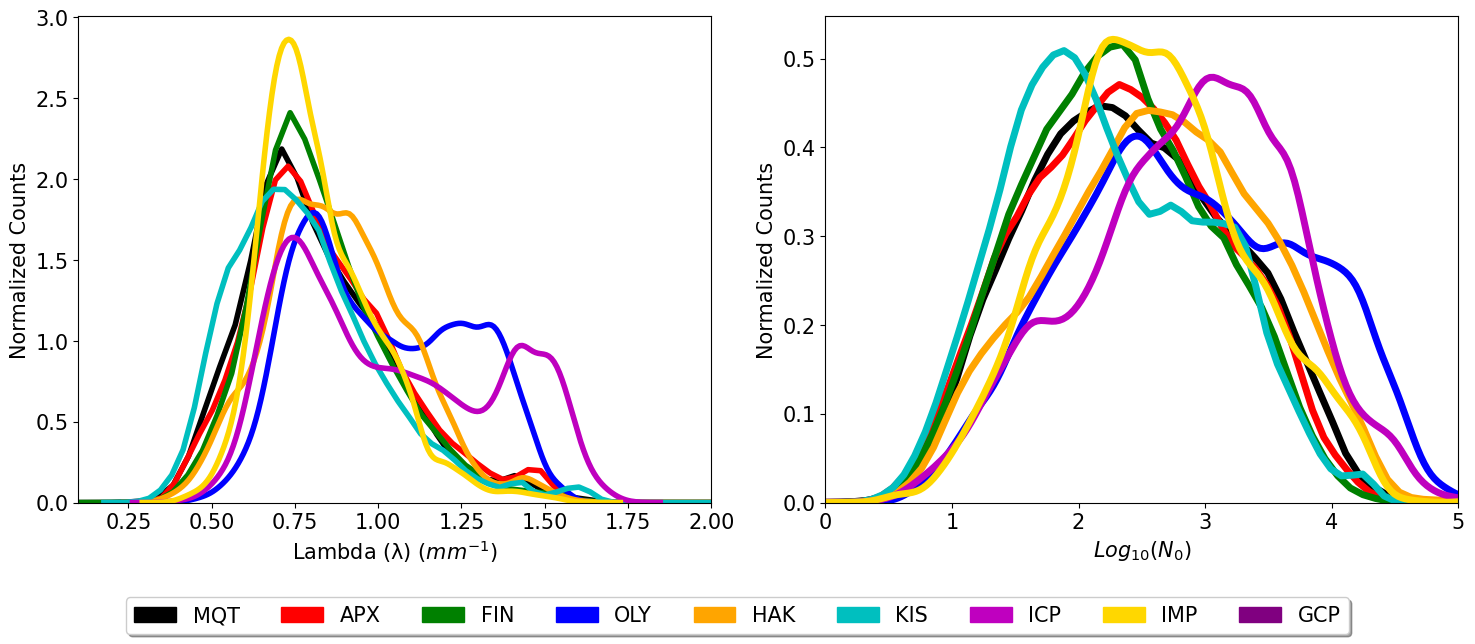

In [10]:
# Plot 1D freq hisograms of vars

def plot_n0_lambda():
    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'GCP']
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    for i, n0 in enumerate(site_N_0_array):
        lam = site_lambda_array[i]
        sns.kdeplot(lam, ax=axes[0], color=colors[i], linewidth=4.0, label=names[i])
        sns.kdeplot(np.ma.log10(n0), ax=axes[1], color=colors[i], linewidth=5.0, label=names[i])

    axes[0].set_xlim(0.1, 2)
    axes[0].set_xlabel("Lambda (λ) ($mm^{-1}$)")
    axes[0].set_ylabel("Normalized Counts")
    # axes[0].set_title('Lambda Distribution')
    axes[1].set_xlabel("$Log_{10}(N_0)$")
    axes[1].set_ylabel("Normalized Counts")
    # axes[1].set_title('$N_{0}$ Distribution')
    axes[1].set_xlim(0, 5)

    # Create legend handles
    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'GCP']
    legend_handles = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, names)]

    # Add a single custom legend at the bottom
    fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, 0), fancybox=True, shadow=True, ncol=9)

    plt.tight_layout(rect=[0, -0.1, 1, 1])

    plt.tight_layout()
    plt.show()

plot_n0_lambda()

In [11]:
def replace_vars(data):
    concatenated_subarray = data[6] + data[7]
    data[6] = concatenated_subarray
    del data[7]
    return data

def create_1d_hist_min_vars():
    names = ['MQT', 'APX', 'FIN', 'HUR', 'HAUK', 'KIS', 'KO1', 'KO2', 'IMP']
    base_folder = '/Users/fraserking/Development/pip_processing/data/converted'
    cmap = plt.get_cmap('inferno')
    cmap.set_bad(color='black')

    # Initialize arrays to store N0 and lambda values
    site_ed_array = []
    site_rr_array = []
    site_nrr_array = []
    site_vvd_array = []

    for site_name in names:
        print(f"Working on {site_name}")
        
        ed_list = []
        rr_list = []
        nrr_list = []
        vvd_list = []

        subdirs = [d for d in os.listdir(base_folder) if os.path.isdir(os.path.join(base_folder, d))]
        matching_subdirs = [d for d in subdirs if site_name in d]
        
        for subdir in matching_subdirs:
            full_path = os.path.join(base_folder, subdir)
            print(f"Processing subdirectory: {full_path}")

            vars = ['netCDF/adjusted_edensity_lwe_rate', 'netCDF/velocity_distributions']
            
            for i, var in enumerate(vars):
                netcdf_path = os.path.join(full_path, var)
                if os.path.exists(netcdf_path):
                    all_files = os.listdir(netcdf_path)
                    nc_files = [f for f in all_files if f.endswith('.nc')]
                    
                    for nc_file in nc_files:
                        nc_file_path = os.path.join(netcdf_path, nc_file)
                        # print(f"Processing file: {nc_file_path}")
                        ds_pip = xr.open_dataset(nc_file_path)   

                        if i == 0:
                            ed = ds_pip['ed'].values
                            rr = ds_pip['rr'].values
                            nrr = ds_pip['nrr'].values
                            ed_list.append(ed.flatten())
                            rr_list.append(rr.flatten())
                            nrr_list.append(nrr.flatten())
                        else:
                            vvd = ds_pip['vvd'].T.values
                            vvd_list.append(vvd.flatten())


        site_ed_array.append(ed_list)
        site_rr_array.append(rr_list)
        site_nrr_array.append(nrr_list)
        site_vvd_array.append(vvd_list)

    return site_ed_array, site_rr_array, site_nrr_array, site_vvd_array

site_ed_array, site_rr_array, site_nrr_array, site_vvd_array = create_1d_hist_min_vars()

site_ed_array = replace_vars(site_ed_array)
site_rr_array = replace_vars(site_rr_array)
site_nrr_array = replace_vars(site_nrr_array)
site_vvd_array = replace_vars(site_vvd_array)



Working on MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2017_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2016_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2015_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2022_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2021_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2020_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2018_MQT
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2019_MQT
Working on APX
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2022_APX
Working on FIN
Processing subdirectory: /Users/fraserking/Development/pip_processing/data/converted/2019_FIN
Processing subd

In [12]:
def flatten_2d_list(lst):
    flat_list = []
    for sublist in lst:
        for item in sublist:
            flat_list.append(item)
    return flat_list

def create_dataframe(arr):
    transformed_data = []
    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'GCP']

    for i,row in enumerate(arr):
        site = names[i]
        values = flatten_2d_list(row)
        for value in values:
            transformed_data.append([site, value])

    return pd.DataFrame(transformed_data, columns=['Site', 'Value'])

df_ed = create_dataframe(site_ed_array)
# df_ed['Value'] = df_ed['Value'].clip(0, 1)
df_rr = create_dataframe(site_rr_array)
# df_rr['Value'] = df_rr['Value'].clip(0, None)
df_nrr = create_dataframe(site_nrr_array)
# df_nrr['Value'] = df_nrr['Value'].clip(0, None)
# df_vvd = create_dataframe(site_vvd_array)
# df_vvd['Value'] = df_vvd['Value'].clip(0, None)

# print(df_vvd)


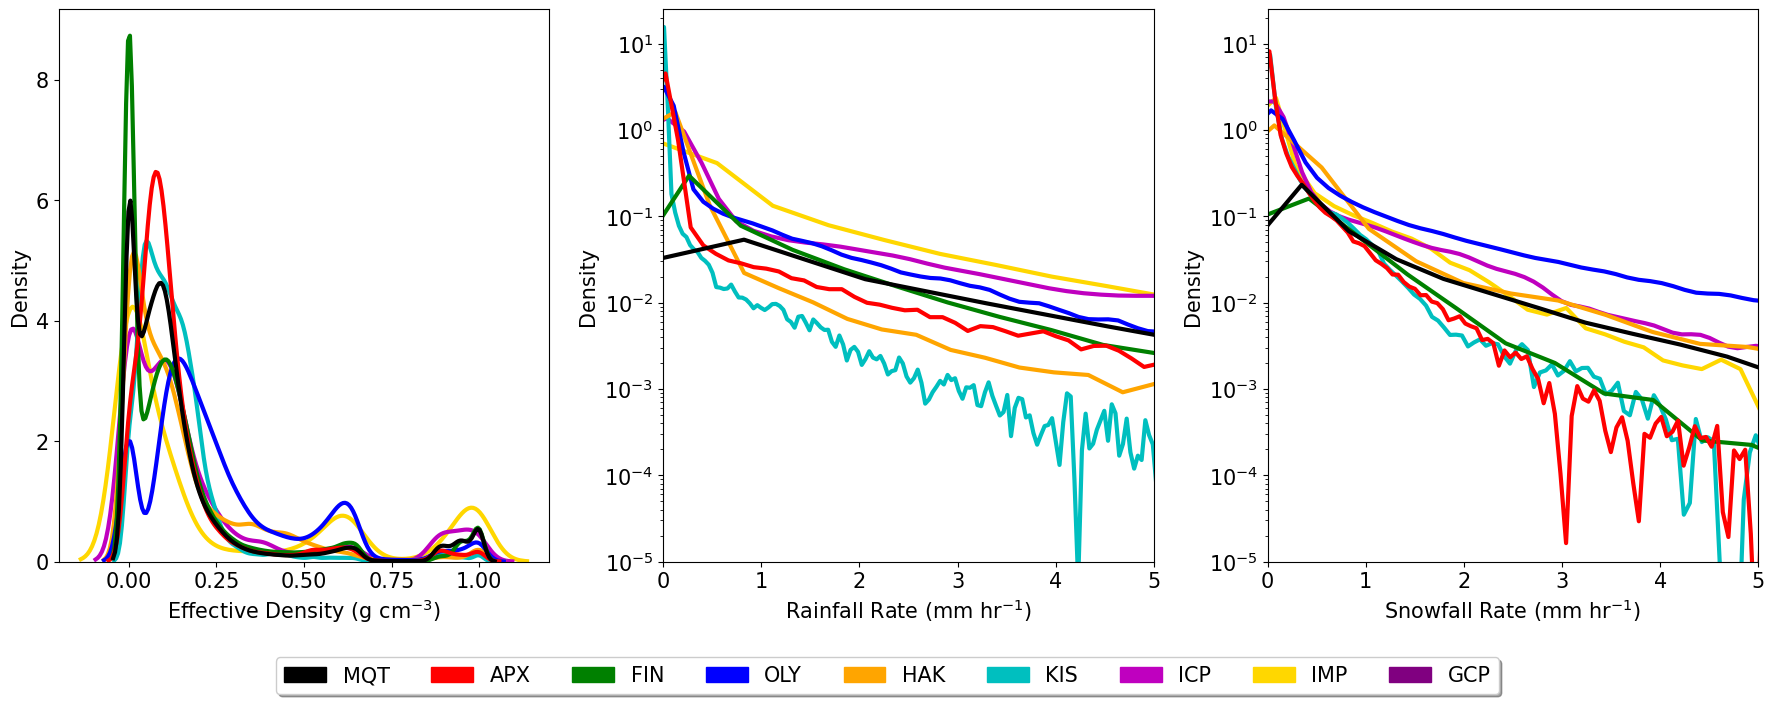

In [13]:
def plot_min_vars(ax, variable, title, use_log, colors):
    names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'GCP']
    
    sns.kdeplot(data=variable, x='Value', hue="Site", common_norm=False, ax=ax, palette=colors, lw=3)
    ax.get_legend().set_visible(False)
    ax.set_xlabel(title)
    if use_log:
        ax.set_yscale('log')
        ax.set_ylim(0.00001, 25)
        ax.set_xlim(0, 5)

# Initialize colors and figure
colors = ['black', 'r', 'g', 'b', 'orange', 'c', 'm', 'gold', 'purple']
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plot the individual subplots
plot_min_vars(axs[0], df_ed, 'Effective Density (g cm$^{-3}$)', False, colors)
plot_min_vars(axs[1], df_rr, 'Rainfall Rate (mm hr$^{-1}$)', True, colors)
plot_min_vars(axs[2], df_nrr, 'Snowfall Rate (mm hr$^{-1}$)', True, colors)

# Create legend handles
names = ['MQT', 'APX', 'FIN', 'OLY', 'HAK', 'KIS', 'ICP', 'IMP', 'GCP']
legend_handles = [mpatches.Patch(color=color, label=name) for color, name in zip(colors, names)]

# Add a single custom legend at the bottom
fig.legend(handles=legend_handles, loc='upper center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=9)

plt.tight_layout(rect=[0, -0.1, 1, 1])
plt.show()